In [19]:
#Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Load Dataset
df = pd.read_csv('customer_data.csv') 
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
#Data Exploration
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
#Clean TotalCharges 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

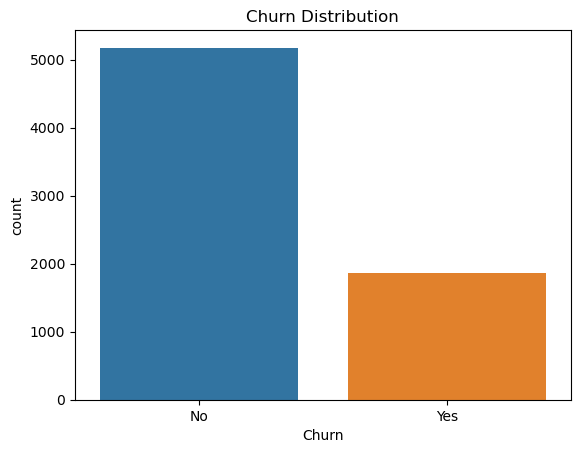

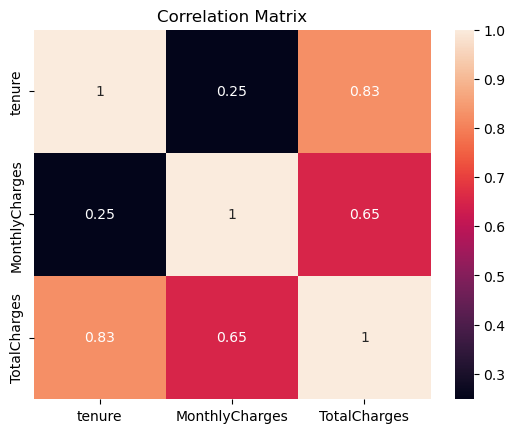

In [10]:
#EDA 
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

#Correlation Heatmap
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
sns.heatmap(df[numeric_cols].corr(), annot=True)
plt.title("Correlation Matrix")
plt.show()


In [11]:
#Encode Categorical Variables
df.drop('customerID', axis=1, inplace=True)

#Binary Encoding
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0})

#Multi-category Encoding
multi_cat_cols = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
                  'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                  'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

df = pd.get_dummies(df, columns=multi_cat_cols, drop_first=True)

In [12]:
#Feature Scaling
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])


In [13]:
#Train-Test Split
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [14]:
#Model Training - Random Forest (as a baseline)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy: 0.7920511000709723
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1035
           1       0.64      0.51      0.56       374

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



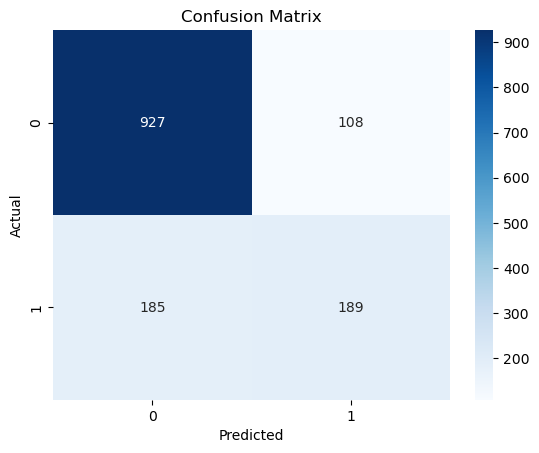

In [15]:
#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
#Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Re-evaluate with best model
y_pred_best = best_model.predict(X_test)
print("Tuned Accuracy:", accuracy_score(y_test, y_pred_best))
print("Tuned Classification Report:\n", classification_report(y_test, y_pred_best))


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Tuned Accuracy: 0.8019872249822569
Tuned Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



Tuned Accuracy: 80.2%
The model correctly predicts churn or non-churn for about 80% of the test data, indicating a decent overall performance.

Classification Report Breakdown:
Class 0 (Non-Churn):
Precision: 84% – The model is accurate 84% of the time when predicting that a customer will not churn.
Recall: 90% – The model correctly identifies 90% of the customers who did not churn.
F1-Score: 87% – A balanced measure combining both precision and recall for non-churning customers.

Class 1 (Churn):
Precision: 66% – The model is correct 66% of the time when predicting that a customer will churn.
Recall: 52% – The model identifies 52% of the actual churners.


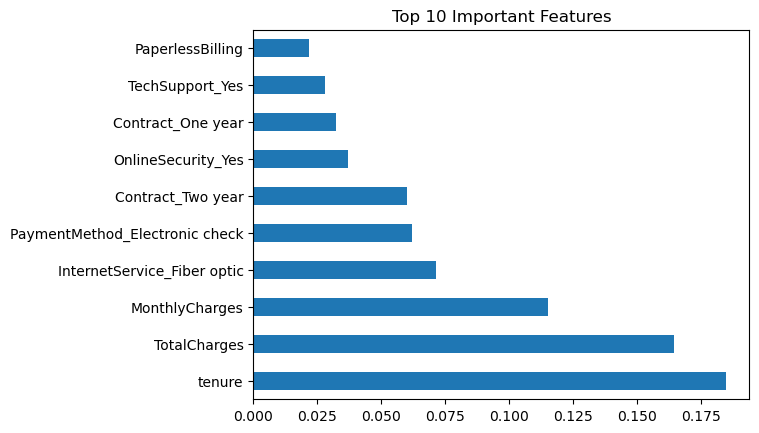

In [17]:
#Feature Importance (Interpretability)
importances = pd.Series(best_model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Important Features")
plt.show()


In [20]:
# Feature Importances
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
print("Top 5 most important features:")
print(feature_importances.sort_values(ascending=False).head(5))

Top 5 most important features:
TotalCharges                      0.193938
MonthlyCharges                    0.168911
tenure                            0.168235
PaymentMethod_Electronic check    0.042407
InternetService_Fiber optic       0.039034
dtype: float64



TotalCharges(0.194)- Customers who have paid more over time are less likely to churn (or have different patterns). It captures customer lifetime value.

MonthlyCharges(0.169)- High monthly bills might cause customers to leave — strongly related to churn risk.

tenure(0.168)- The longer a customer has been with the company, the less likely they are to churn — loyalty matters.

PaymentMethod_Electronic check(0.042)- Customers who pay via electronic check may churn more often — possibly due to billing issues or dissatisfaction.

InternetService_Fiber optic(0.039)- Fiber optic users might have different churn behavior than DSL/no internet — could be due to pricing, reliability, etc.

